In this notebook we try to estimate the dimensionality of the dynamic trajectory subspace.

### Helpful articles
- [Supplementary material from AI Poincare](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.126.180604/poincare_supplemental_materialv2.pdf)
- [Interpretable conservation law estimation by deriving the symmetries of dynamics from trained deep neural networks](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.103.033303) cited in AI Poincare.

In [1]:
%pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pytorch_lightning as pl

In [2]:
import utils
from experiments import *

In [3]:
import wandb
wandb.init(project="Autoencoders Trajectory (dp)")

wandb: Currently logged in as: waleko (ai-prentice). Use `wandb login --relogin` to force relogin


In [4]:
class AE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, intermediate_dim: int):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, hidden_dim),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
def rand_point(dim=3):
    x = np.random.rand(dim)
    x[0] *= np.random.choice([-1, 1])
    x[1] *= np.random.choice([-1, 1])
    return x / np.linalg.norm(x)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" # cpu is faster ??

In [7]:
def train_model(traj, experiment_name: str, hidden_layer_dim: int, epochs=1000, intermediate_dim=20, batch_size=10):
    input_dim = traj.shape[1]

    model = AE(input_dim, hidden_layer_dim, intermediate_dim).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    
    train_len = int(traj.shape[0] * 0.8)

    traj_train, traj_val = random_split(traj, [train_len, traj.shape[0] - train_len])

    train_dataloader = DataLoader(traj_train, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(traj_val, batch_size=batch_size, shuffle=True)

    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for batch_pts in train_dataloader:
            inp = batch_pts.float().to(device)
            output = model(inp)
            loss = criterion(output, inp)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        epoch_rms = np.sqrt(running_loss / batch_size)
        wandb.log({f"{experiment_name}_{hidden_layer_dim}_train_loss": epoch_rms})
        # validate
        running_loss = 0
        with torch.no_grad():
            for batch_pts in val_dataloader:
                inp = batch_pts.float().to(device)
                output = model(inp)
                loss = criterion(output, inp)
                running_loss += loss.item()
        val_loss = np.sqrt(running_loss / batch_size)
        wandb.log({f"{experiment_name}_{hidden_layer_dim}_val_loss": val_loss})
    return model

In [8]:
def full_train(traj, experiment_name, max_hidden_size, epochs=1000, intermediate_dim=20, batch_size=32):
    models = []
    model_loss = []
    criteriton = nn.MSELoss().to(device)
    
    for hidden_layer_size in tqdm(range(1, max_hidden_size + 1)):
        model = train_model(traj, experiment_name, hidden_layer_size, intermediate_dim=intermediate_dim, batch_size=batch_size, epochs=epochs)
        models.append(model)
        with torch.no_grad():
            test_traj = torch.Tensor(traj).to(device)
            loss = criteriton(model(test_traj), test_traj)
            model_loss.append(np.sqrt(loss.item()))
    return models, model_loss

In [9]:
decision_threshold = 0.02

In [10]:
def plot_losses(experiment_name, n_eff, model_loss, max_hidden_size):
    plt.scatter(range(1, max_hidden_size + 1), np.array(model_loss), c=[1 if x < n_eff else 0 for x in range(1, max_hidden_size + 1)])
    plt.axhline(y=decision_threshold, color='blue', linestyle='--')
    title = f"{experiment_name} n_eff={n_eff}"
    plt.title(title)
    plt.xlabel("hidden layer size")
    plt.ylabel("r.m.s. loss after auto-encoder")
    plt.savefig(f"plot_{experiment_name}_2e-2")
    wandb.log({title: wandb.Image(f"plot_{experiment_name}_2e-2.png")})
    plt.show()
    plt.close()

In [11]:
def train_n_eff(exp: PhysExperiment, epochs=1000, intermediate_dim=20, batch_size=10):
    traj = exp.single_trajectory(42)
    n_eff = exp.n_eff
    model = train_model(traj, exp.experiment_name, n_eff, epochs, intermediate_dim, batch_size)
    test_traj = torch.Tensor(traj).to(device)
    with torch.no_grad():
        embedding = model.encoder(test_traj).detach().numpy()
        transformed = model(test_traj).detach().numpy()

        all_trajs = np.concatenate((traj, transformed))
        color = np.concatenate((np.zeros(shape=(traj.shape[0], 1)), np.ones(shape=(transformed.shape[0], 1))))
        exported = np.append(all_trajs, color, axis=1)
        table = wandb.Table(columns=exp.column_names + ["transformed"], data=exported)
        wandb.log({f"{exp.experiment_name} before/after": table})
    if n_eff == 1:
        # coloring
        traj_with_color = np.append(traj, embedding, axis=1)
        wandb.log({f"{exp.experiment_name} coloring for n_eff=1 embedding": wandb.Table(exp.column_names + ["color"], data=traj_with_color)})
    elif n_eff == 2:
        # 2d embedding
        wandb.log({f"{exp.experiment_name} 2d n_eff embedding": wandb.Table(["projection1", "projection2"], embedding)})
    elif n_eff == 3:
        # 3d embedding
        wandb.log({f"{exp.experiment_name} 3d n_eff embedding": wandb.Object3D(embedding)})
    else:
        wandb.alert(f"no visual representation for n_eff={n_eff} with experiment {exp.experiment_name}")

## 5-dimensional sphere (example)

In [35]:
experiment_name = "sphere5"
traj_s5 = np.array([rand_point(dim=5) for x in range(1000)])
print(traj_s5.shape)
n_eff = 4 # ground truth
max_hidden_size = 6
epochs = 5000

(1000, 5)


In [14]:
models_s5, epochs_s5 = full_train(traj_s5, experiment_name, max_hidden_size, epochs=epochs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

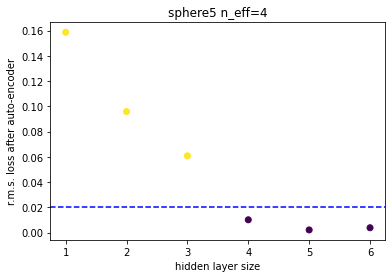

In [36]:
plot_losses(experiment_name, n_eff, epochs_s5, max_hidden_size)

## Pendulum

In [37]:
exp = Pendulum
experiment_name = exp.experiment_name
traj_p = exp.single_trajectory(42)
print(traj_p.shape)
n_eff = exp.n_eff # ground truth
max_hidden_size = n_eff + 3
epochs = 5000

(1000, 2)


In [17]:
models_p, epochs_p = full_train(traj_p, experiment_name, max_hidden_size, epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

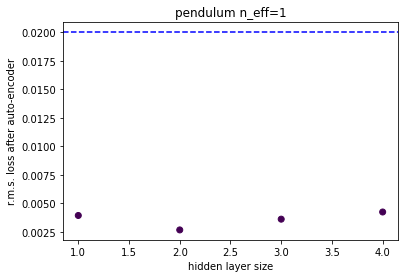

In [38]:
plot_losses(experiment_name, n_eff, epochs_p, max_hidden_size)

## Harmonic oscillator

In [12]:
exp = HarmonicOscillator
experiment_name = exp.experiment_name
traj_h = exp.single_trajectory(42)
print(traj_h.shape)
n_eff = exp.n_eff # ground truth
max_hidden_size = n_eff + 3
epochs = 5000

(1000, 2)


In [13]:
prime_model_h = train_model(traj_h, experiment_name, n_eff)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
with torch.no_grad():
    test_traj = torch.Tensor(traj_h).to(device)
    colors = prime_model_h.encoder(test_traj).detach().numpy()
    traj_with_color = np.append(traj_h, colors, axis=1)

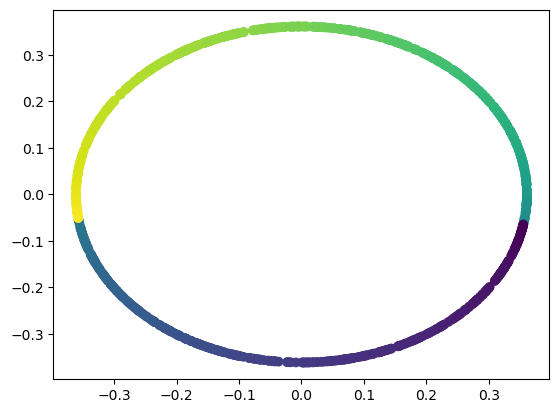

In [20]:
plt.scatter(traj_with_color[:, 0], traj_with_color[:, 1], c=traj_with_color[:, 2])

In [20]:
models_h, epochs_h = full_train(traj_h, experiment_name, max_hidden_size, epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

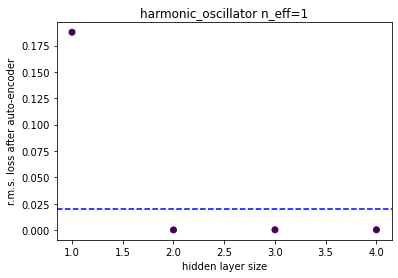

In [40]:
plot_losses(experiment_name, n_eff, epochs_h, max_hidden_size)

## Double pendulum

In [41]:
exp = DoublePendulum
experiment_name = exp.experiment_name
traj_dp = exp.single_trajectory(42)
print(traj_dp.shape)
n_eff = exp.n_eff # ground truth
max_hidden_size = n_eff + 3
epochs = 5000

(1000, 4)


In [24]:
models_dp, epochs_dp = full_train(traj_dp, experiment_name, max_hidden_size, epochs=epochs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

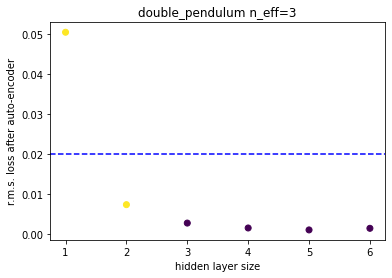

In [42]:
plot_losses(experiment_name, n_eff, epochs_dp, max_hidden_size)

## Coupled oscillator

In [43]:
exp = CoupledOscillator
experiment_name = exp.experiment_name
traj_co = exp.single_trajectory(42)
print(traj_co.shape)
n_eff = exp.n_eff # ground truth
max_hidden_size = n_eff + 3
epochs = 5000

(1000, 4)


In [27]:
models_co, epochs_co = full_train(traj_co, experiment_name, max_hidden_size, epochs=epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

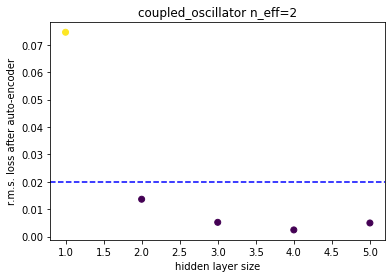

In [44]:
plot_losses(experiment_name, n_eff, epochs_co, max_hidden_size)

## Kepler problem

In [45]:
exp = KeplerProblem
experiment_name = exp.experiment_name
traj_kp = exp.single_trajectory(42)
print(traj_kp.shape)
n_eff = exp.n_eff # ground truth
max_hidden_size = n_eff + 3
epochs = 5000

(1000, 4)


In [30]:
models_kp, epochs_kp = full_train(traj_kp, experiment_name, max_hidden_size, epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

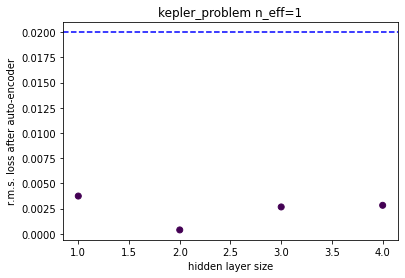

In [46]:
plot_losses(experiment_name, n_eff, epochs_kp, max_hidden_size)

In [ ]:
for exp in [DoublePendulumSmallEnergy, DoublePendulumLargeEnergy]:
    traj = exp.single_trajectory(42)
    max_hidden_size = exp.n_eff + 2
    models, epochs = full_train(traj, exp.experiment_name, max_hidden_size, epochs=5000)
    plot_losses(exp.experiment_name, exp.n_eff, epochs, max_hidden_size)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [34]:
wandb.finish()

coupled_oscillator_2_train_loss,███▆▆▆▆▆▆▆▆▆▆▆▅▄▃▃▂▂▁▁▁▃▁▁▁▁▂▂▃▃▂▂▂▁▂▃▂▂
coupled_oscillator_2_val_loss,███▆▆▆▆▆▆▆▆▆▆▆▅▄▃▃▂▂▁▂▁▂▁▁▁▂▃▂▃▃▂▂▂▂▂▂▂▁
double_pendulum_3_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
double_pendulum_3_val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
harmonic_oscillator_1_train_loss,██████▃▃▃▃▃▂▁▄▃▃▃▂▂▁▁▂▂▁▁▂▃▂▂▂▂▁▁▂▁▂▃▁▁▁
harmonic_oscillator_1_val_loss,██████▃▄▃▃▃▂▂▇▃▃▃▂▁▁▁▂▂▁▁▂▃▂▃▂▂▁▁▂▂▃▃▂▂▂
kepler_problem_1_train_loss,█▃▄▃▂▂▅▁▁▁▁▁▅▆▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂
kepler_problem_1_val_loss,█▃▅▃▂▂▅▂▃▂▁▁▄▇▂▃▃▂▂▂▁▁▁▃▁▁▁▁▁▂▂▂▂▁▂▁▁▁▁▂
pendulum_1_train_loss,█▃▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pendulum_1_val_loss,█▄▄▂▂▂▁▂▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁
coupled_oscillator_2_train_loss,0.04853
